In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import  peak_widths
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from scipy.stats import linregress


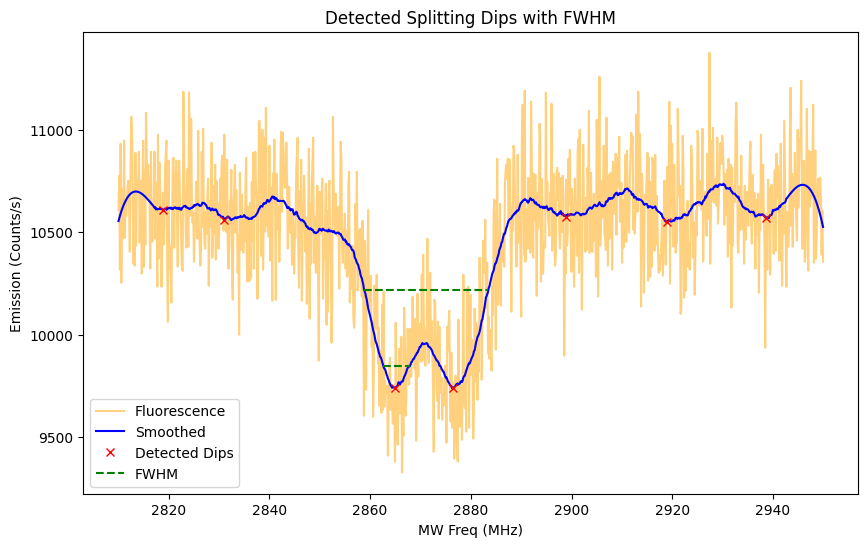

Top two dip frequencies (MHz): [2864.95, 2876.43]

FWHM results (used as uncertainty):
Dip 1: 2864.950 MHz ± 5.311 MHz uncertainty
Dip 2: 2876.430 MHz ± 24.652 MHz uncertainty


In [5]:

# 1. Read the Excel file
df = pd.read_excel("/Users/adampearl/Documents/191/GitHub/nv-center/Second_draft/code/Splitting/0.22.xlsx")

# 2. Extract columns
freq = df["MW Freq (MHz) - Fluorescence"]
fluorescence = df["Emission (Counts/s) - Fluorescence"]

# 3. Invert the signal to detect dips
inv_fluorescence = -np.array(fluorescence)

# 4. Apply Savitzky-Golay filter
window_length = 101  # Make sure window_length is odd
polyorder = 3
smoothed_fluorescence = savgol_filter(inv_fluorescence, window_length=window_length, polyorder=polyorder)

# 5. Find peaks (dips in original data)
peaks, properties = find_peaks(smoothed_fluorescence, width=30)

# 6. Sort peaks by strength and get top two
top_two_indices = np.argsort(smoothed_fluorescence[peaks])[-2:]  # indices in 'peaks' array
top_two_peaks = peaks[top_two_indices]
top_two_freqs = freq[top_two_peaks]

# -----------------
# FWHM Analysis for Uncertainty
# -----------------

# Calculate FWHM for each of the top two peaks
results_half = peak_widths(smoothed_fluorescence, top_two_peaks, rel_height=0.5)

# Convert widths from sample number to frequency units
freq_step = np.mean(np.diff(freq))  # Assuming uniform frequency spacing
fwhms = results_half[0] * freq_step

# 7. Plot the results
plt.figure(figsize=(10,6))
plt.plot(freq, fluorescence, label="Fluorescence", alpha=0.5, color="orange")
plt.plot(freq, -smoothed_fluorescence, label="Smoothed", color="blue")
plt.plot(freq[peaks], -smoothed_fluorescence[peaks], 'rx', label="Detected Dips")

# Plot FWHM lines
for i in range(2):
    left_idx = int(results_half[2][i])
    right_idx = int(results_half[3][i])
    plt.hlines(-results_half[1][i], freq[left_idx], freq[right_idx], color='green', linestyle='--', label='FWHM' if i == 0 else "")

plt.xlabel("MW Freq (MHz)")
plt.ylabel("Emission (Counts/s)")
plt.title("Detected Splitting Dips with FWHM")
plt.legend()
plt.show()

print("Top two dip frequencies (MHz):", list(top_two_freqs))

print("\nFWHM results (used as uncertainty):")
for i, (peak_freq, fwhm) in enumerate(zip(top_two_freqs, fwhms)):
    print(f"Dip {i+1}: {peak_freq:.3f} MHz ± {fwhm:.3f} MHz uncertainty")


In [39]:
fwhms

array([9.0311154 , 9.61708675])

In [ ]:
def freq_peaks(file):
    # 1. Read the Excel file
    # 1. Read the Excel file
    df = pd.read_excel(file)

    # 2. Extract columns
    freq = df["MW Freq (MHz) - Fluorescence"]
    fluorescence = df["Emission (Counts/s) - Fluorescence"]

    # 3. Invert the signal to detect dips
    inv_fluorescence = -np.array(fluorescence)

    # 4. Apply Savitzky-Golay filter
    window_length = 100  # Make sure window_length is odd
    polyorder = 3
    smoothed_fluorescence = savgol_filter(inv_fluorescence, window_length=window_length, polyorder=polyorder)

    # 5. Find peaks (dips in original data)
    peaks, properties = find_peaks(smoothed_fluorescence, width=30)

    # 6. Sort peaks by strength and get top two
    top_two_indices = np.argsort(smoothed_fluorescence[peaks])[-2:]  # indices in 'peaks' array
    top_two_peaks = peaks[top_two_indices]
    top_two_freqs = freq[top_two_peaks]

    # -----------------
    # FWHM Analysis for Uncertainty
    # -----------------

    # Calculate FWHM for each of the top two peaks
    results_half = peak_widths(smoothed_fluorescence, top_two_peaks, rel_height=0.5)

    # Convert widths from sample number to frequency units
    freq_step = np.mean(np.diff(freq))  # Assuming uniform frequency spacing
    fwhms = results_half[0] * freq_step


    
    return top_two_peaks, fwhms


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


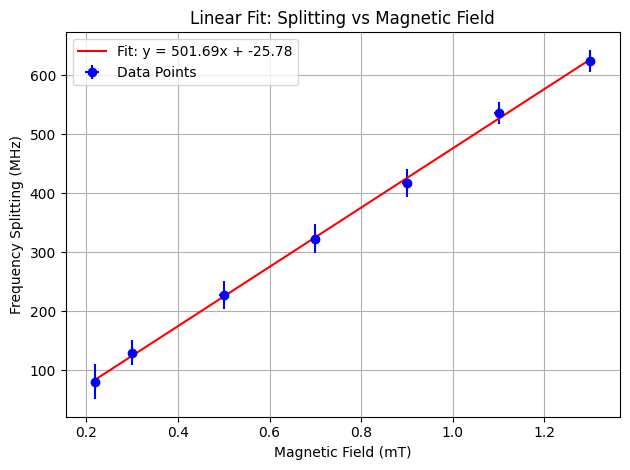

Slope: 501.6883 MHz/T
Intercept: -25.7821 MHz
R²: 0.9991


In [44]:
names = {0.22: '0.22',0.3: '0.30',0.5: '0.50',0.7: '0.7',0.9: '0.90',1.10: '1.10',1.30: '1.30'}
magnetic_fields = [0.22,0.30,0.50,0.7,0.90,1.10 ,1.30]
distance_array = []
y_uncertainties = []
for m in magnetic_fields:
    file = f"/Users/adampearl/Documents/191/GitHub/nv-center/Second_draft/code/Splitting/{names[m]}.xlsx"
    top_freqs, fwhms = freq_peaks(file)
    distance = np.abs(top_freqs[1] - top_freqs[0])
    distance_array.append(distance)
    uncertainty = np.sum(fwhms)
    y_uncertainties.append(uncertainty)
    
# Convert to numpy arrays for fitting
x = np.array(magnetic_fields)
y = np.array(distance_array)

x_uncertainties = np.full_like(x, 0.01)
# Linear regression fit
slope, intercept, r_value, p_value, std_err = linregress(x, y)
fit_line = slope * x + intercept

# Plotting
plt.errorbar(x, y,xerr = x_uncertainties, yerr = y_uncertainties, fmt = 'o', label="Data Points", color="blue")
plt.plot(x, fit_line, label=f"Fit: y = {slope:.2f}x + {intercept:.2f}", color="red")
plt.xlabel("Magnetic Field (mT)")
plt.ylabel("Frequency Splitting (MHz)")
plt.title("Linear Fit: Splitting vs Magnetic Field")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally print fit details
print(f"Slope: {slope:.4f} MHz/T")
print(f"Intercept: {intercept:.4f} MHz")
print(f"R²: {r_value**2:.4f}")